In [104]:
from collections import Counter
import math
import os
import random
from typing import Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap
import torch
from torch.utils.data import Dataset, DataLoader


output_dir = "./output"
os.makedirs(output_dir, exist_ok=True)

### 1. Data preprocessing
+ 1.1 observation and cleaning
+ 1.2 splitting
+ 1.3 numpy or dataloader

+ download: [Kaggle link](https://www.kaggle.com/datasets/hershyandrew/amzn-dpz-btc-ntfx-adjusted-may-2013may2019)
+ info:
    + columns:
        + AMZN: Amazon
        + DPZ: Domino-Pizza
        + BTC: Bit-Coin-Center
        + NFLX: Netflix
    + 4 inputs -> 4 outputs
+ Dimension:
    + B = batch size
    + S = sequence length = L = Position
    + W = embedding dimension = E = d_model
+ More:
    + [Pytorch official Positional Encoding (S,B,W)](https://pytorch.org/tutorials/beginner/transformer_tutorial.html) Used here
    + [Pytorch official Multi-Head Attention (S,B,W)](https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html)
    + [Pytorch official Transformer Encoder (S,B,W)](https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoder.html)
    + [Pytorch official Transformer (S,B,W)](https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html) Used here
    + [Decoder input 1](https://zhuanlan.zhihu.com/p/107586681), [Decoder input2](https://towardsdatascience.com/a-detailed-guide-to-pytorchs-nn-transformer-module-c80afbc9ffb1)

### Data observation and cleaning

In [66]:
df = pd.read_csv("./portfolio_data.csv")
df

,Date,AMZN,DPZ,BTC,NFLX
0,5/1/2013,248.229996,51.190983,106.250000,30.415714
1,5/2/2013,252.550003,51.987320,98.099998,30.641428
2,5/3/2013,258.049988,52.446388,112.900002,30.492857
3,5/6/2013,255.720001,53.205257,109.599998,30.098572
4,5/7/2013,257.730011,54.151505,113.199997,29.464285
...,...,...,...,...,...
1515,5/8/2019,1917.770020,283.149994,6171.959961,364.369995
1516,5/9/2019,1899.869995,282.160004,6358.290039,362.750000
1517,5/10/2019,1889.979980,278.369995,7191.359863,361.040009
1518,5/13/2019,1822.680054,273.880005,7980.129883,345.260010


In [67]:
# change date to datetime
df["Date"] = pd.to_datetime(df["Date"])

# check time delta
time_delta_list = []
for i in range(len(df)-1):
    time_delta = df.loc[i+1, "Date"] - df.loc[i, "Date"]
    time_delta_list.append(str(time_delta))
Counter(time_delta_list)

Counter({'1 days 00:00:00': 1188,
         '3 days 00:00:00': 276,
         '4 days 00:00:00': 39,
         '2 days 00:00:00': 16})

In [68]:
# check for missing values
df.isnull().sum()

Date    0
AMZN    0
DPZ     0
BTC     0
NFLX    0
dtype: int64

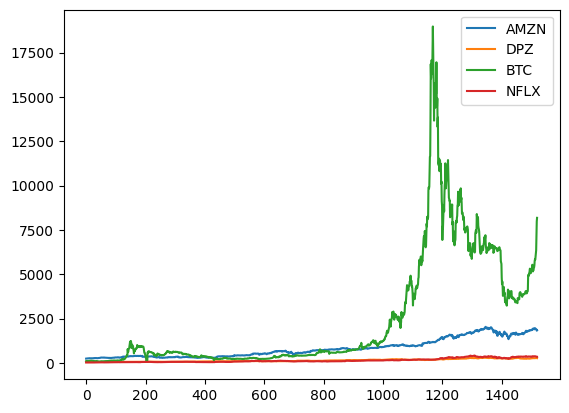

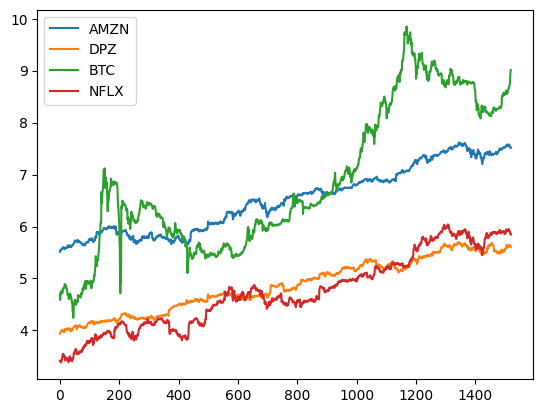

In [69]:
# raw plot
for col in df.columns:
    if col != "Date":
        plt.plot(df[col], label=col)
plt.legend()
plt.show()


# log plot
for col in df.columns:
    if col != "Date":
        plt.plot(np.log(df[col]), label=col)
plt.legend()
plt.show()

In [70]:
# filter columns
df = df.set_index("Date")

# log of values
df = df.apply(np.log)
df

,AMZN,DPZ,BTC,NFLX
Date,,,,
2013-05-01,5.514356,3.935563,4.665795,3.414959
2013-05-02,5.531609,3.951000,4.585987,3.422353
2013-05-03,5.553153,3.959791,4.726502,3.417492
2013-05-06,5.544083,3.974157,4.696837,3.404478
2013-05-07,5.551913,3.991786,4.729156,3.383179
...,...,...,...,...
2019-05-08,7.558918,5.645977,8.727772,5.898170
2019-05-09,7.549541,5.642474,8.757515,5.893714
2019-05-10,7.544322,5.628951,8.880636,5.888989


In [86]:
# sliding window
window_size = 64
dataset = []
for i in range(len(df) - window_size):
    one_data = df.iloc[i: i + window_size].copy()
    # shape = (window_size, num_features) = (64, 4)

    for col in df.columns:
        one_data[f"y_{col}"] = df.iloc[i + window_size][col]
    one_data["series_id"] = i
    # shape = (window_size, num_features * 2 + 1) = (64, 9)

    dataset.append(one_data)
    
dataset = pd.concat(dataset, axis=0)
dataset

,AMZN,DPZ,BTC,NFLX,y_AMZN,y_DPZ,y_BTC,y_NFLX,series_id
Date,,,,,,,,,
2013-05-01,5.514356,3.935563,4.665795,3.414959,5.722179,4.094057,4.649187,3.572025,0
2013-05-02,5.531609,3.951000,4.585987,3.422353,5.722179,4.094057,4.649187,3.572025,0
2013-05-03,5.553153,3.959791,4.726502,3.417492,5.722179,4.094057,4.649187,3.572025,0
2013-05-06,5.544083,3.974157,4.696837,3.404478,5.722179,4.094057,4.649187,3.572025,0
2013-05-07,5.551913,3.991786,4.729156,3.383179,5.722179,4.094057,4.649187,3.572025,0
...,...,...,...,...,...,...,...,...,...
2019-05-07,7.560601,5.625425,8.699300,5.914745,7.517586,5.608959,9.009916,5.845311,1455
2019-05-08,7.558918,5.645977,8.727772,5.898170,7.517586,5.608959,9.009916,5.845311,1455
2019-05-09,7.549541,5.642474,8.757515,5.893714,7.517586,5.608959,9.009916,5.845311,1455


In [87]:
# normalization
dataset_describe = dataset.describe()
dataset_describe

,AMZN,DPZ,BTC,NFLX,y_AMZN,y_DPZ,y_BTC,y_NFLX,series_id
count,93184.000000,93184.000000,93184.000000,93184.000000,93184.000000,93184.000000,93184.000000,93184.000000,93184.000000
mean,6.511656,4.865416,6.871444,4.741871,6.553074,4.899513,6.959337,4.795119,727.500000
std,0.610942,0.494716,1.359865,0.685145,0.614693,0.489436,1.337884,0.680206,420.313152
min,5.514356,3.935563,4.243626,3.383179,5.638106,4.049513,4.632785,3.560153,0.000000
25%,5.915015,4.483364,5.874313,4.149464,5.935316,4.536607,5.937299,4.167434,363.750000
50%,6.527739,4.844898,6.437816,4.644006,6.580305,4.881402,6.479661,4.688221,727.500000
75%,6.919031,5.273201,8.238693,5.235165,7.056313,5.327462,8.281870,5.275982,1091.250000
max,7.620465,5.699225,9.850736,6.037799,7.620465,5.699225,9.850736,6.037799,1455.000000


In [88]:
dataset_describe.to_csv(os.path.join(output_dir, "dataset_describe.csv"))

# keep raw data
dataset_norm = (dataset - dataset_describe.loc["mean"]) / dataset_describe.loc["std"]
dataset_norm["series_id"] = dataset["series_id"]
dataset_norm

,AMZN,DPZ,BTC,NFLX,y_AMZN,y_DPZ,y_BTC,y_NFLX,series_id
Date,,,,,,,,,
2013-05-01,-1.632396,-1.879569,-1.621961,-1.936688,-1.351724,-1.645682,-1.726720,-1.798124,0
2013-05-02,-1.604155,-1.848367,-1.680649,-1.925897,-1.351724,-1.645682,-1.726720,-1.798124,0
2013-05-03,-1.568891,-1.830595,-1.577319,-1.932991,-1.351724,-1.645682,-1.726720,-1.798124,0
2013-05-06,-1.583738,-1.801557,-1.599133,-1.951987,-1.351724,-1.645682,-1.726720,-1.798124,0
2013-05-07,-1.570922,-1.765923,-1.575367,-1.983073,-1.351724,-1.645682,-1.726720,-1.798124,0
...,...,...,...,...,...,...,...,...,...
2019-05-07,1.716931,1.536253,1.344145,1.711864,1.569095,1.449517,1.532703,1.543932,1455
2019-05-08,1.714176,1.577796,1.365082,1.687671,1.569095,1.449517,1.532703,1.543932,1455
2019-05-09,1.698827,1.570716,1.386954,1.681167,1.569095,1.449517,1.532703,1.543932,1455


In [90]:
dataset

,AMZN,DPZ,BTC,NFLX,y_AMZN,y_DPZ,y_BTC,y_NFLX,series_id
Date,,,,,,,,,
2013-05-01,5.514356,3.935563,4.665795,3.414959,5.722179,4.094057,4.649187,3.572025,0
2013-05-02,5.531609,3.951000,4.585987,3.422353,5.722179,4.094057,4.649187,3.572025,0
2013-05-03,5.553153,3.959791,4.726502,3.417492,5.722179,4.094057,4.649187,3.572025,0
2013-05-06,5.544083,3.974157,4.696837,3.404478,5.722179,4.094057,4.649187,3.572025,0
2013-05-07,5.551913,3.991786,4.729156,3.383179,5.722179,4.094057,4.649187,3.572025,0
...,...,...,...,...,...,...,...,...,...
2019-05-07,7.560601,5.625425,8.699300,5.914745,7.517586,5.608959,9.009916,5.845311,1455
2019-05-08,7.558918,5.645977,8.727772,5.898170,7.517586,5.608959,9.009916,5.845311,1455
2019-05-09,7.549541,5.642474,8.757515,5.893714,7.517586,5.608959,9.009916,5.845311,1455


In [100]:
# splitting

seed = 0
random.seed(seed)

n_all = len(dataset) // window_size
n_train = int(n_all * 0.8)
train_indices = random.sample(list(range(n_all)), n_train)
valid_indices = list(set(range(n_all)) - set(train_indices))
train_indices_df = pd.DataFrame({"series_id": train_indices})
valid_indices_df = pd.DataFrame({"series_id": valid_indices})

train_dataset = dataset.merge(train_indices_df, on="series_id")
valid_dataset = dataset.merge(valid_indices_df, on="series_id")
train_dataset_norm = dataset_norm.merge(train_indices_df, on="series_id")
valid_dataset_norm = dataset_norm.merge(valid_indices_df, on="series_id")

train_dataset_norm.shape, valid_dataset_norm.shape

((74496, 9), (18688, 9))

In [103]:
num_input_features = 4

train_x = train_dataset_norm.iloc[:, :num_input_features].to_numpy()
valid_x = valid_dataset_norm.iloc[:, :num_input_features].to_numpy()
train_x = train_x.reshape(-1, window_size, num_input_features)
valid_x = valid_x.reshape(-1, window_size, num_input_features)

train_y = train_dataset_norm.iloc[:, num_input_features:-1].to_numpy()
valid_y = valid_dataset_norm.iloc[:, num_input_features:-1].to_numpy()
train_y = train_y[::window_size, :]
valid_y = valid_y[::window_size, :]

train_x.shape, train_y.shape, valid_x.shape, valid_y.shape

((1164, 64, 4), (1164, 4), (292, 64, 4), (292, 4))

In [106]:
class ToyTimeSeriesRegressionDataset(Dataset):
    def __init__(self, x: np.ndarray, y: np.ndarray):
        """
        Args:
            x (np.ndarray): shape = (num_data, window_size, num_input_features)
            y (torch.Tensor): shape = (num_data, window_size, num_output_features)
        """
        self.x = torch.tensor(x, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    
    def __len__(self) -> int:
        return len(self.x)
    
    def __getitem__(self, index) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Returns:
            x (torch.Tensor): shape = (window_size, num_input_features)
            y (torch.Tensor): shape = (num_output_features,)
        """
        return self.x[index], self.y[index]


trainset = ToyTimeSeriesRegressionDataset(train_x, train_y)
validset = ToyTimeSeriesRegressionDataset(valid_x, valid_y)
trainset[0]

(tensor([[-1.6324, -1.8796, -1.6220, -1.9367],
         [-1.6042, -1.8484, -1.6806, -1.9259],
         [-1.5689, -1.8306, -1.5773, -1.9330],
         [-1.5837, -1.8016, -1.5991, -1.9520],
         [-1.5709, -1.7659, -1.5754, -1.9831],
         [-1.5649, -1.7572, -1.5780, -1.9665],
         [-1.5556, -1.7708, -1.5467, -1.9129],
         [-1.5339, -1.7582, -1.5597, -1.9043],
         [-1.5284, -1.7502, -1.5872, -1.8279],
         [-1.5050, -1.7244, -1.5688, -1.7990],
         [-1.5158, -1.7715, -1.5435, -1.7413],
         [-1.5308, -1.7955, -1.5113, -1.7801],
         [-1.4954, -1.7740, -1.5131, -1.7680],
         [-1.5092, -1.8040, -1.5150, -1.7646],
         [-1.5017, -1.7959, -1.5095, -1.7797],
         [-1.5380, -1.8080, -1.4948, -1.8332],
         [-1.5453, -1.7172, -1.4563, -1.8484],
         [-1.5457, -1.7340, -1.4624, -1.8320],
         [-1.5113, -1.7019, -1.4610, -1.9279],
         [-1.5221, -1.7148, -1.4804, -1.9201],
         [-1.5141, -1.6975, -1.4803, -1.8713],
         [-1.

In [107]:
batch_size = 16

trainloader = DataLoader(trainset, batch_size=batch_size, pin_memory=False, shuffle=False, drop_last=True)
validloader = DataLoader(validset, batch_size=batch_size, pin_memory=False, shuffle=False, drop_last=True)

### 2. Model prepatation
+ 2.1 model
+ 2.2 loss
+ 2.3 more hyperparameters

In [ ]:
class ToyTimeSeriesRegressionLSTM(torch.nn.Module):
    def __init__(self, num_input_features: int, num_output_features: int, window_size: int):
        super().__init__()
        self.lstm = torch.nn.LSTM(
            input_size = num_input_features,
            hidden_size = window_size,
            num_layers = 1,
            batch_first=True,
        )
        self.lstm_hidden = torch.nn.LSTM(
            input_size = 128,
            hidden_size = 64,
            num_layers = 1,
            batch_first=True,
        )
        self.flatten = torch.nn.Flatten()
        self.dense = torch.nn.Linear(64 * num_output_features, 4)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x (torch.Tensor): shape=(window_size, num_input_features)
        Returns:
            x (torch.Tensor): shape=(num_output_features,)
        """
        x, (_, _) = self.lstm(x)
        x = x.flatten(start_dim=1)
        x = self.dense(x)
        return x

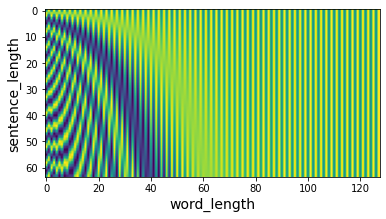

torch.Size([292, 64, 4])

In [ ]:
# data (B,S,W)
# PE class instantiation (W,dropout,S)
# PE call function (S,W) = PE(pos,i), i in [0,1,2,...,d_model-1] = sin(pos/10000^(2*i/dmodel)) if i%2==0 else cos(pos/10000^(2*i/dmodel))
class PositionalEncoding(torch.nn.Module): # e.g. S=64, W=d_model=4
    def __init__(self, d_model:int, dropout: float=0.1, max_len:int=5000): # (W,-,S)
        super().__init__() # must because self.register_buffer
        self.dropout = nn.Dropout(p=dropout)
        position = torch.arange(max_len).unsqueeze(1)   # [[0],[1],[2],...,[5000]]
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model)) # torch.arange(0,4,2)=[0,2]
        # div_term = e^([0,2]*(-log_e(10000))*1/d) = (e^(log_e(10000)))^([0,2]*(-1/dmodel)) = 1/10000^([0,2]/dmodel)
        pe = torch.zeros(max_len, 1, d_model)           # (S,1,W)
        pe[:, 0, 0::2] = torch.sin(position * div_term) # (position*div_term).shape=(5000,1,64)
        pe[:, 0, 1::2] = torch.cos(position * div_term) # pe.shape=(5000,1,64)
        self.register_buffer('pe', pe) # remain at cpu and non-trainable
    
    def forward(self, x):
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)] # x.size(0)=S
        return self.dropout(x)

PE = PositionalEncoding(128,0,64) # (W,-,S)
plt.imshow(PE.pe[:,0,:])
plt.ylabel("sentence_length", fontsize=14)
plt.xlabel("word_length", fontsize=14)
plt.show()

PositionalEncoding(4,0)( torch.Tensor(xVal) ).shape

In [11]:
# reference only
attn = torch.nn.MultiheadAttention(4,2) # (W,H)
x = torch.rand(64,16,4) # (S,B,W)
a, _ = attn(x,x,x)
a.shape

torch.Size([64, 16, 4])

In [12]:
# reference only
encoder_layer = nn.TransformerEncoderLayer(d_model=4, nhead=2)
transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=6)
src = torch.rand(64,16,4) # (S,B,W)
out = transformer_encoder(src)
out.shape # (S,B,W)

torch.Size([64, 16, 4])

In [13]:
# reference only
decoder_layer = nn.TransformerDecoderLayer(d_model=4, nhead=2)
transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=6)
memory = torch.rand(64,16,4) # (S,B,W)
tgt = torch.rand(64,16,4)
out = transformer_decoder(tgt, memory)
out.shape

torch.Size([64, 16, 4])

In [14]:
# reference only
transformer_model = nn.Transformer(d_model=4, nhead=2, num_encoder_layers=6, num_decoder_layers=6, dim_feedforward=128)
src = torch.rand((64,16,4))
tgt = torch.rand((64,16,4))
out = transformer_model(src, tgt)
out.shape

torch.Size([64, 16, 4])

### Model

In [48]:
class MyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.positionalEncoding = PositionalEncoding(d_model=4, dropout=0, max_len=64)
        self.transformer = nn.Transformer(d_model=4, nhead=2, num_encoder_layers=12, num_decoder_layers=6, dim_feedforward=2048)
        self.mask = torch.zeros(64,16,4).to('cuda') # S,B,W
        if True:
            self.mask = torch.Tensor([[-999]*4 for i in range(64)])
            self.mask = self.mask.triu(diagonal=1)
            self.mask = torch.stack([ self.mask for i in range(16) ])
            self.mask = self.mask.permute(1,0,2).to('cuda')
        self.dense = torch.nn.Linear(64*4,4)
        
    def forward(self, x):
        x = x.permute(1,0,2)
        x = self.positionalEncoding(x)
        x = x.to('cuda')
        x = self.transformer(x, self.mask)
        x = x.permute(1,0,2)
        x = x.flatten(start_dim=1)
        x = self.dense(x)
        return x
    
model = MyModel().to('cuda')

with torch.no_grad():
    pred = model( next(iter(trainDataLoader))[0].to('cuda') )
    print( pred.shape )

torch.Size([16, 4])


In [49]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_func = nn.MSELoss()

epochs = 20
history = {"trainLossL":[], "valLossL":[]}
for ep in range(epochs):
    print(f"Epoch: {ep+1}/{epochs}")
    # train
    trainLoss= 0.
    for i,(X,y) in enumerate(trainDataLoader):
        X, y = X.to('cuda'), y.to('cuda')
        optimizer.zero_grad()    # zero the parameter gradients
        pred = model(X)          # f(x) and f'(x)
        loss = loss_func(y,pred)    # compute loss
        loss.backward()          # send loss to torch
        optimizer.step()         # update model parameters by torch loss 
        trainLoss += loss.item() / len(trainDataset)
        print(f"\rbatch={i+1}/{len(trainDataLoader)}, trainLoss={trainLoss:.5f}", end="")
    history["trainLossL"].append(trainLoss)
    # validation
    valLoss = 0.
    for i,(X,y) in enumerate(valDataLoader):
        y = y.to('cuda')
        with torch.no_grad():
            X, y = X.to('cuda'), y.to('cuda')
            pred = model(X)
            loss = loss_func(pred,y)
            valLoss += loss.item() / len(valDataset)
            print(f"\rbatch={i+1}/{len(valDataLoader)}, valLoss={valLoss:.5f}", end="")
    history["valLossL"].append(valLoss)
    print()

Epoch: 1/20
batch=18/18, valLoss=0.0147033
Epoch: 2/20
batch=18/18, valLoss=0.0103721
Epoch: 3/20
batch=18/18, valLoss=0.0095798
Epoch: 4/20
batch=18/18, valLoss=0.0096120
Epoch: 5/20
batch=18/18, valLoss=0.0089653
Epoch: 6/20
batch=18/18, valLoss=0.0104366
Epoch: 7/20
batch=18/18, valLoss=0.0054293
Epoch: 8/20
batch=18/18, valLoss=0.0050622
Epoch: 9/20
batch=18/18, valLoss=0.0046186
Epoch: 10/20
batch=18/18, valLoss=0.0045995
Epoch: 11/20
batch=18/18, valLoss=0.0042741
Epoch: 12/20
batch=18/18, valLoss=0.0037921
Epoch: 13/20
batch=18/18, valLoss=0.0046914
Epoch: 14/20
batch=18/18, valLoss=0.0041532
Epoch: 15/20
batch=18/18, valLoss=0.0038008
Epoch: 16/20
batch=18/18, valLoss=0.0033585
Epoch: 17/20
batch=18/18, valLoss=0.0038918
Epoch: 18/20
batch=18/18, valLoss=0.0034782
Epoch: 19/20
batch=18/18, valLoss=0.0047589
Epoch: 20/20
batch=18/18, valLoss=0.0033021


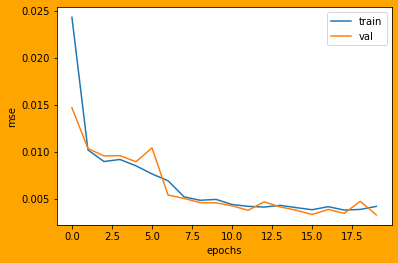

In [51]:
f = plt.figure()
f.set_facecolor("orange")
plt.plot(history['trainLossL'])
plt.plot(history['valLossL'])
plt.xlabel("epochs")
plt.ylabel("mse")
plt.legend(labels=['train','val'])
plt.show()

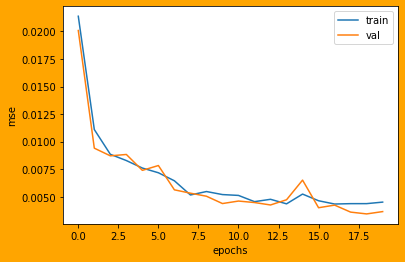

In [23]:
f = plt.figure()
f.set_facecolor("orange")
plt.plot(history['trainLossL'])
plt.plot(history['valLossL'])
plt.xlabel("epochs")
plt.ylabel("mse")
plt.legend(labels=['train','val'])
plt.show()

In [27]:
with torch.no_grad():
    realL, predL = np.array([[0,0,0,0]]), np.array([[0,0,0,0]])
    for X,y in valDataLoader:
        realL = np.concatenate([realL,y])
        pred = model(X.to('cuda')).cpu().numpy()
        predL = np.concatenate([predL,pred])
    realL, predL = realL[1:], predL[1:]
    
print(realL.shape, predL.shape)

(288, 4) (288, 4)


In [28]:
real = realL*np.array(stds)+np.array(means)
pred = predL*np.array(stds)+np.array(means)

D = { **{f"real_{i}":real[:,i] for i in range(4)}, **{f"pred_{i}":pred[:,i] for i in range(4)} }
df = pd.DataFrame( D )
df

,real_0,real_1,real_2,real_3,pred_0,pred_1,pred_2,pred_3
0,322.700004,74.416548,360.910017,66.694283,339.923036,74.865992,678.977925,55.078994
1,1614.370004,288.124722,3375.330058,344.709992,1722.594727,272.293046,5195.387579,315.694489
2,1990.000031,283.310367,6491.999900,369.950001,1782.507719,273.306720,5820.723313,311.826284
3,326.439993,63.157846,202.990074,50.712856,327.381039,75.989431,849.485400,45.746866
4,326.279984,70.907421,504.799938,64.504288,355.452630,80.598171,335.399271,47.825378
...,...,...,...,...,...,...,...,...
283,744.429989,140.970840,651.109897,85.990001,640.054268,131.498139,958.963541,108.198517
284,292.709980,67.875771,441.109905,45.791431,351.538017,78.904521,873.378906,44.424863
285,1159.790029,177.052568,16850.310356,185.199996,1071.792668,163.955425,10715.506249,216.613698
286,372.369984,74.810203,658.299953,64.785716,318.070791,73.739171,439.864266,45.107493


In [34]:
class MyModel2(nn.Module):
    def __init__(self):
        super().__init__()
        self.dense = torch.nn.Linear(64*4,4)
        
    def forward(self, x):
        x = x.flatten(start_dim=1)
        x = self.dense(x)
        return x
    
model = MyModel2()#.to('cuda')

with torch.no_grad():
    pred = model( next(iter(trainDataLoader))[0] )
    print( pred.shape )

torch.Size([16, 4])


In [35]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_func = nn.MSELoss()

epochs = 20
history = {"trainLossL":[], "valLossL":[]}
for ep in range(epochs):
    print(f"Epoch: {ep+1}/{epochs}")
    # train
    trainLoss= 0.
    for i,(X,y) in enumerate(trainDataLoader):
        optimizer.zero_grad()    # zero the parameter gradients
        pred = model(X)          # f(x) and f'(x)
        loss = loss_func(y,pred)    # compute loss
        loss.backward()          # send loss to torch
        optimizer.step()         # update model parameters by torch loss 
        trainLoss += loss.item() / len(trainDataset)
    print(f"\rbatch={i+1}/{len(trainDataLoader)}, trainLoss={trainLoss:.5f}", end="")
    history["trainLossL"].append(trainLoss)
    # validation
    valLoss = 0.
    for i,(X,y) in enumerate(valDataLoader):
        with torch.no_grad():
            pred = model(X)
            loss = loss_func(pred,y)
            valLoss += loss.item() / len(valDataset)
    print(f"\rbatch={i+1}/{len(valDataLoader)}, valLoss={valLoss:.5f}", end="")
    history["valLossL"].append(valLoss)
    print()
    #break

Epoch: 1/20
batch=18/18, valLoss=0.0329379
Epoch: 2/20
batch=18/18, valLoss=0.0140874
Epoch: 3/20
batch=18/18, valLoss=0.0106581
Epoch: 4/20
batch=18/18, valLoss=0.0082432
Epoch: 5/20
batch=18/18, valLoss=0.0064451
Epoch: 6/20
batch=18/18, valLoss=0.0051820
Epoch: 7/20
batch=18/18, valLoss=0.0043129
Epoch: 8/20
batch=18/18, valLoss=0.0037366
Epoch: 9/20
batch=18/18, valLoss=0.0033424
Epoch: 10/20
batch=18/18, valLoss=0.0030795
Epoch: 11/20
batch=18/18, valLoss=0.0028774
Epoch: 12/20
batch=18/18, valLoss=0.0027258
Epoch: 13/20
batch=18/18, valLoss=0.0026045
Epoch: 14/20
batch=18/18, valLoss=0.0025034
Epoch: 15/20
batch=18/18, valLoss=0.0024024
Epoch: 16/20
batch=18/18, valLoss=0.0023216
Epoch: 17/20
batch=18/18, valLoss=0.0022408
Epoch: 18/20
batch=18/18, valLoss=0.0021700
Epoch: 19/20
batch=18/18, valLoss=0.0021193
Epoch: 20/20
batch=18/18, valLoss=0.0020487


In [36]:
with torch.no_grad():
    realL, predL = np.array([[0,0,0,0]]), np.array([[0,0,0,0]])
    for X,y in valDataLoader:
        realL = np.concatenate([realL,y])
        pred = model(X).numpy()
        predL = np.concatenate([predL,pred])
    realL, predL = realL[1:], predL[1:]
    
print(realL.shape, predL.shape)

(288, 4) (288, 4)


In [37]:
real = realL*np.array(stds)+np.array(means)
pred = predL*np.array(stds)+np.array(means)

D = { **{f"real_{i}":real[:,i] for i in range(4)}, **{f"pred_{i}":pred[:,i] for i in range(4)} }
df = pd.DataFrame( D )
df

,real_0,real_1,real_2,real_3,pred_0,pred_1,pred_2,pred_3
0,322.700004,74.416548,360.910017,66.694283,329.089093,75.882828,477.925146,62.985200
1,1614.370004,288.124722,3375.330058,344.709992,1755.219823,260.774598,4240.529065,315.965511
2,1990.000031,283.310367,6491.999900,369.950001,1904.397929,283.755417,6250.277542,373.089856
3,326.439993,63.157846,202.990074,50.712856,267.649656,65.161037,259.202125,42.309344
4,326.279984,70.907421,504.799938,64.504288,323.806312,72.943598,688.020653,57.739553
...,...,...,...,...,...,...,...,...
283,744.429989,140.970840,651.109897,85.990001,629.138729,128.412123,683.706895,101.561739
284,292.709980,67.875771,441.109905,45.791431,306.774592,70.960038,520.780910,54.578615
285,1159.790029,177.052568,16850.310356,185.199996,1197.940669,189.841660,8789.052815,198.177198
286,372.369984,74.810203,658.299953,64.785716,337.260370,69.552210,564.609188,61.656409


In [31]:
lstm = nn.LSTM(input_size=4, hidden_size=128, num_layers=3)
x = torch.randn(64,16,4) # (S,B,W)
output, _ = lstm(x)
output.shape

torch.Size([64, 16, 128])

In [42]:
class MyModel3(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=4, hidden_size=4, num_layers=3)
        self.dense = torch.nn.Linear(64*4,4)
        
    def forward(self, x):
        x, (_, _) = self.lstm(x)
        x = x.flatten(start_dim=1)
        x = self.dense(x)
        return x
    
model = MyModel3()#.to('cuda')

with torch.no_grad():
    pred = model( next(iter(trainDataLoader))[0] )
    print( pred.shape )

torch.Size([16, 4])


In [43]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_func = nn.MSELoss()

epochs = 100
history = {"trainLossL":[], "valLossL":[]}
for ep in range(epochs):
    print(f"Epoch: {ep+1}/{epochs}")
    # train
    trainLoss= 0.
    for i,(X,y) in enumerate(trainDataLoader):
        optimizer.zero_grad()    # zero the parameter gradients
        pred = model(X)          # f(x) and f'(x)
        loss = loss_func(y,pred)    # compute loss
        loss.backward()          # send loss to torch
        optimizer.step()         # update model parameters by torch loss 
        trainLoss += loss.item() / len(trainDataset)
        print(f"\rbatch={i+1}/{len(trainDataLoader)}, trainLoss={trainLoss:.5f}", end="")
    history["trainLossL"].append(trainLoss)
    # validation
    valLoss = 0.
    for i,(X,y) in enumerate(valDataLoader):
        with torch.no_grad():
            pred = model(X)
            loss = loss_func(pred,y)
            valLoss += loss.item() / len(valDataset)
            print(f"\rbatch={i+1}/{len(valDataLoader)}, valLoss={valLoss:.5f}", end="")
    history["valLossL"].append(valLoss)
    print()

Epoch: 1/100
batch=18/18, valLoss=0.0613783
Epoch: 2/100
batch=18/18, valLoss=0.0613138
Epoch: 3/100
batch=18/18, valLoss=0.0612122
Epoch: 4/100
batch=18/18, valLoss=0.0609699
Epoch: 5/100
batch=18/18, valLoss=0.0605257
Epoch: 6/100
batch=18/18, valLoss=0.0598290
Epoch: 7/100
batch=18/18, valLoss=0.0588089
Epoch: 8/100
batch=18/18, valLoss=0.0574351
Epoch: 9/100
batch=18/18, valLoss=0.0557073
Epoch: 10/100
batch=18/18, valLoss=0.0536358
Epoch: 11/100
batch=18/18, valLoss=0.0512713
Epoch: 12/100
batch=18/18, valLoss=0.0487045
Epoch: 13/100
batch=18/18, valLoss=0.0459962
Epoch: 14/100
batch=18/18, valLoss=0.0432073
Epoch: 15/100
batch=18/18, valLoss=0.0403982
Epoch: 16/100
batch=18/18, valLoss=0.0376095
Epoch: 17/100
batch=18/18, valLoss=0.0348914
Epoch: 18/100
batch=18/18, valLoss=0.0323044
Epoch: 19/100
batch=18/18, valLoss=0.0298489
Epoch: 20/100
batch=18/18, valLoss=0.0275750
Epoch: 21/100
batch=18/18, valLoss=0.0254830
Epoch: 22/100
batch=18/18, valLoss=0.0235830
Epoch: 23/100
batch